In [30]:
import pandas as pd
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.metrics import roc_auc_score, roc_curve, cohen_kappa_score, precision_score, recall_score, \
    precision_recall_curve

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.semi_supervised import LabelSpreading, LabelPropagation
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.base import clone
from scipy import stats
import sklearn.preprocessing
import pickle
from tqdm import tqdm

import os
from gensim.models import KeyedVectors
from gensim.downloader import base_dir

import random

In [3]:
#Dataframe  generated in analye-data.ipynb
df = pd.read_json("Trec_data/Preprocessed_labelled.json", orient='records', lines=True)
df

,eventID,eventType,postID,postCategories,postPriority,text,entities,extended_entities,favorite_count,hashtagEntities,...,num_terms,num_unique_words,num_urls,num_words,vader compound,vader neg,vader neu,vader pos,regression_priority,sparseCategories
0,fireColorado2012,wildfire,212311994286620672,[MultimediaShare],Unknown,RT @CBSDenver: The copter is on the way to the...,"{'symbols': [], 'urls': [], 'hashtags': [{'tex...",None,0.0,None,...,25,25,0,28,0.0000,0.000,1.000,0.00,0.00,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
1,fireColorado2012,wildfire,217746356842926080,[MultimediaShare],Medium,RT @ColoradoRapids: Photo of #FlagStaffFire in...,"{'symbols': [], 'urls': [], 'hashtags': [{'tex...",None,0.0,None,...,23,25,0,26,0.0000,0.000,1.000,0.00,0.50,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
2,fireColorado2012,wildfire,217732012314861568,[FirstPartyObservation],Medium,2 wildfires in Boulder County. We can see smok...,"{'symbols': [], 'urls': [], 'hashtags': [], 'u...",None,0.0,None,...,12,13,0,14,0.0000,0.000,1.000,0.00,0.50,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
3,fireColorado2012,wildfire,216961334129078272,[Discussion],Low,RT @Jon_G3: Seeing 1/3 of Colorado on fire mak...,"{'symbols': [], 'urls': [], 'hashtags': [{'tex...",None,0.0,None,...,22,22,0,23,-0.6124,0.306,0.563,0.13,0.25,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,fireColorado2012,wildfire,212552860590813184,[MultimediaShare],Medium,RT @dhorning11: RT @LarimerCounty: #HighParkFi...,"{'symbols': [], 'urls': [{'expanded_url': 'htt...",None,0.0,None,...,15,17,1,20,0.0000,0.000,1.000,0.00,0.50,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38071,tennesseeTornadoOutbreak2020,tornado,1235236359310368768,"[ThirdPartyObservation, Weather, Location, Mul...",Low,Hottest Google Search in 31.2 hrs. Nashville t...,"{'hashtags': [], 'urls': [{'url': 'https://t.c...",None,0.0,None,...,16,14,1,22,0.0000,0.000,1.000,0.00,0.25,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, ..."
38072,tennesseeTornadoOutbreak2020,tornado,1235337290144239616,"[ThirdPartyObservation, Location, MultimediaSh...",Low,A live report is next on the Nashville tornado...,"{'hashtags': [], 'urls': [], 'user_mentions': ...",None,0.0,None,...,11,11,0,11,0.0000,0.000,1.000,0.00,0.25,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, ..."
38073,tennesseeTornadoOutbreak2020,tornado,1235258820139638784,"[ThirdPartyObservation, Weather, Location, Mul...",Low,Officials are still cleaning up after tornadoe...,"{'hashtags': [], 'urls': [], 'user_mentions': ...",None,0.0,None,...,20,21,0,22,0.0000,0.000,1.000,0.00,0.25,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, ..."
38074,tennesseeTornadoOutbreak2020,tornado,1235253249957126144,"[ThirdPartyObservation, Weather, Location, Mul...",Low,Putnam County: Cookeville area tornado victims...,"{'hashtags': [], 'urls': [{'url': 'https://t.c...",None,0.0,None,...,8,9,1,9,-0.3182,0.247,0.753,0.00,0.25,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, ..."


# **`Generate Event Types`**

In [4]:
fullEventTypes = df['eventType'].unique()
eventTypes = []
for event in fullEventTypes:
    events = df.loc[df['eventType'] == event]['eventID'].unique()
    if events.size > 1:
        eventTypes.append(event)
print(eventTypes)

['wildfire', 'earthquake', 'flood', 'typhoon', 'shooting', 'bombing', 'storm']


# **`Model Related Methods`**

In [5]:
def train_data(data, column, heldout_ids):
    if type(heldout_ids) != list:
        heldout_ids = [heldout_ids]
    training = data.loc[~data[column].isin(heldout_ids)]
    
    return training

def test_data(data, column, heldout_ids):
    if type(heldout_ids) != list:
        heldout_ids = [heldout_ids]
    test = data.loc[data[column].isin(heldout_ids)]
    
    return test

In [15]:
def generate_scores_by_event(data, event, features, target, modelType):
    f1_accum = []
    accuracy_accum = []
    
    labels = data[target].unique()
    label_f1_accum = {} #Dict by unique labels
    label_score_accum = {}
    for label in labels:
        label_f1_accum[label] = []
        label_score_accum[label] = []
    
    eventIDs = data.loc[data['eventType']==event]['eventID'].unique()
    for heldoutEvent in tqdm(eventIDs, position=1,desc=event):
        #Create training and test dataframe
        training = train_data(data, 'eventID', heldoutEvent)
        test = test_data(data, 'eventID', heldoutEvent)
        
        X_train = training[features]
        y_train = training[target]        
        X_test = test[features]
        y_test = test[target]
        
        if isinstance(y_train, pd.Series):
            y_train = []
            for val in training[target]:
                y_train.append(np.array(val))
            y_train= np.array(y_train)
        if isinstance(y_test, pd.Series):
            y_test = []
            for val in test[target]:
                y_test.append(np.array(val))
            y_test= np.array(y_test)
            
        
        #generate model
        model = clone(modelType)
        model.fit(X_train, y_train)
        
        #Test model
        y_infer_local = model.predict(X_test)
        local_f1 = f1_score(y_test, y_infer_local, average="macro", zero_division=0)
        local_score = model.score(X_test, y_test)
        
        #Seperate scores per label
        for label in labels:
            label_ids = test[target]==label
            x_label = X_test[label_ids]
            y_label = y_test[label_ids]
            y_infer_label = y_infer_local[label_ids]
            
            if x_label.size == 0:
                continue
            
            label_f1 = f1_score(y_label, y_infer_label, average="macro", zero_division=0)
            label_score = model.score(x_label, y_label)
            
            label_f1_accum[label].append(label_f1)
            label_score_accum[label].append(label_score)
        
        accuracy_accum.append(local_score)
        f1_accum.append(local_f1)
        
        for label in labels: #Prevent blank
            if len(label_f1_accum[label]):
                label_f1_accum.pop(label, None)
                label_score_accum.pop(label, None)
        
    return [accuracy_accum, f1_accum, label_score_accum, label_f1_accum] #Accuracy is 0, F1 is 1, label Acc is 2, label F1 is 3

In [7]:
#Currently unused
def save_model(model, filename):
    pickle.dump(model, open(filename, 'wb'))
    
def load_model(filename):
    model = pickle.load(open(filename, 'rb'))
    return model

# **`Generate Generic Variables`**

In [8]:
features = ["num_chars", "num_chars_total", 
            "num_terms", "num_words", "num_unique_words", "vader neg", "vader pos",
            "vader neu", "vader compound", 
            "num_hashtags", "num_mentions", 
            "num_urls", 
            "is_retweet", "num_media",
            "is_verified", 
            "caps_ratio"]

#I think you need to make a list of lists

rf_params = {
    'random_state': 1337,
    'class_weight': 'balanced',
    'n_estimators': 128, 
    'n_jobs': -1,
    'max_depth': 50,
    'max_features': 14,
    'min_samples_leaf': 33,
    'min_samples_split': 96,
    'verbose': 0
}

# **`Generate and Test postPriority Models`**

In [16]:
prioLabel = 'postPriority'
prioModel = RandomForestClassifier(**rf_params) #(**modelParameters)

genPrioScores = {}
specPrioScores = {}

#generate general model
for event in tqdm(eventTypes, position=0, desc='Events'):
    #print('Event: ' + event)
    eventDF = df.loc[df['eventType']==event]
    genPrioScores[event] = generate_scores_by_event(df, event, features, prioLabel, prioModel)
    specPrioScores[event] = generate_scores_by_event(eventDF, event, features, prioLabel, prioModel)
    

wildfire: 100%|██████████| 5/5 [01:04<00:00, 12.84s/it]

earthquake: 100%|██████████| 11/11 [02:22<00:00, 12.92s/it]

flood: 100%|██████████| 11/11 [02:24<00:00, 13.09s/it]

typhoon: 100%|██████████| 9/9 [01:56<00:00, 12.96s/it]

shooting: 100%|██████████| 10/10 [02:09<00:00, 12.98s/it]

bombing: 100%|██████████| 3/3 [00:38<00:00, 12.89s/it]

storm: 100%|██████████| 2/2 [00:26<00:00, 13.12s/it]

Events: 100%|██████████| 7/7 [12:23<00:00, 106.25s/it]


In [51]:
#Store prio scores in readable format
labels = ['Low', 'Medium', 'High', 'Critical']

prioScoreDf = pd.DataFrame()#columns=cols)
for event in eventTypes:
    row = pd.Series(
        {
            'genScores': genPrioScores[event][0:1], 'specScores': specPrioScores[event][0:1],
            'genLabelScores': genPrioScores[event][2:3], 'specLabelScores': specPrioScores[event][2:3],
            'avgAccGen': np.mean(genPrioScores[event][0]), 'avgAccSpec': np.mean(specPrioScores[event][0]),
            'avgF1Gen': np.mean(genPrioScores[event][1]), 'avgF1Spec': np.mean(specPrioScores[event][1]),
            'semAccGen': stats.sem(genPrioScores[event][0]), 'semAccSpec': stats.sem(specPrioScores[event][0]),
            'semF1Gen': stats.sem(genPrioScores[event][1]), 'semF1Spec': stats.sem(specPrioScores[event][1])
        }, name=event)
    #Add label specific columns
    for label in labels:
        if label in genPrioScores[event][2] and label in specPrioScores[event][2]:
            labelCol = pd.Series(
                {
                    'avgAccGen' + label: np.mean(genPrioScores[event][2][label]), 'avgAccSpec' + label: np.mean(specPrioScores[event][2][label]),
                    'avgF1Gen' + label: np.mean(genPrioScores[event][3][label]), 'avgF1Spec' + label: np.mean(specPrioScores[event][3][label]),
                    'semAccGen' + label: stats.sem(genPrioScores[event][2][label]), 'semAccSpec' + label: stats.sem(specPrioScores[event][2][label]),
                    'semF1Gen' + label: stats.sem(genPrioScores[event][3][label]), 'semF1Spec' + label: stats.sem(specPrioScores[event][3][label])
                })
            row = row.append(labelCol)
    row.name = event
    prioScoreDf = prioScoreDf.append(row)
    
#Reorder for easy readability
cols = ['genScores', 'specScores', 'genLabelScores', 'specLabelScores']
scoreTypes = ['F1', 'Acc']
accumTypes = ['avg', 'sem']
testTypes = ['Gen', 'Spec']

for score in scoreTypes:
    for accum in accumTypes:
        for test in testTypes:
            cols.append(accum+score+test)
            for label in labels:
                cols.append(accum+score+test+label)

print(cols)
prioScoreDf = prioScoreDf[cols]
prioScoreDf

['genScores', 'specScores', 'genLabelScores', 'specLabelScores', 'avgF1Gen', 'avgF1GenLow', 'avgF1GenMedium', 'avgF1GenHigh', 'avgF1GenCritical', 'avgF1Spec', 'avgF1SpecLow', 'avgF1SpecMedium', 'avgF1SpecHigh', 'avgF1SpecCritical', 'semF1Gen', 'semF1GenLow', 'semF1GenMedium', 'semF1GenHigh', 'semF1GenCritical', 'semF1Spec', 'semF1SpecLow', 'semF1SpecMedium', 'semF1SpecHigh', 'semF1SpecCritical', 'avgAccGen', 'avgAccGenLow', 'avgAccGenMedium', 'avgAccGenHigh', 'avgAccGenCritical', 'avgAccSpec', 'avgAccSpecLow', 'avgAccSpecMedium', 'avgAccSpecHigh', 'avgAccSpecCritical', 'semAccGen', 'semAccGenLow', 'semAccGenMedium', 'semAccGenHigh', 'semAccGenCritical', 'semAccSpec', 'semAccSpecLow', 'semAccSpecMedium', 'semAccSpecHigh', 'semAccSpecCritical']


,genScores,specScores,genLabelScores,specLabelScores,avgF1Gen,avgF1GenLow,avgF1GenMedium,avgF1GenHigh,avgF1GenCritical,avgF1Spec,...,semAccGen,semAccGenLow,semAccGenMedium,semAccGenHigh,semAccGenCritical,semAccSpec,semAccSpecLow,semAccSpecMedium,semAccSpecHigh,semAccSpecCritical
wildfire,"[[0.3464052287581699, 0.33511586452762926, 0.5...","[[0.37254901960784315, 0.4117647058823529, 0.5...","[{'Unknown': [0.0], 'Medium': [0.3469387755102...","[{'Unknown': [0.0], 'Medium': [0.2448979591836...",0.198208,0.133364,0.157157,0.153814,0.009804,0.187518,...,0.040656,0.062984,0.075249,0.025334,0.020833,0.047287,0.072289,0.072770,0.057945,0.308859
earthquake,"[[0.3389830508474576, 0.44545454545454544, 0.2...","[[0.4067796610169492, 0.39090909090909093, 0.3...","[{'Unknown': [], 'Medium': [0.5, 0.42857142857...","[{'Low': [0.42142857142857143, 0.5757575757575...",0.189896,0.142831,0.090484,0.112394,0.004808,0.210901,...,0.034203,0.047690,0.066456,0.052633,0.010417,0.031686,0.052541,0.095183,0.087772,0.034994
flood,"[[0.46994535519125685, 0.363013698630137, 0.38...","[[0.4644808743169399, 0.4041095890410959, 0.34...","[{'Unknown': [], 'Medium': [0.543859649122807,...","[{'High': [0.4772727272727273, 0.2769230769230...",0.204074,0.135030,0.199237,0.114268,0.061224,0.237013,...,0.026854,0.034400,0.095435,0.039262,0.071429,0.032977,0.046327,0.058025,0.056955,0.141557
typhoon,"[[0.4606741573033708, 0.38209606986899564, 0.4...","[[0.5056179775280899, 0.3864628820960699, 0.41...","[{'Unknown': [], 'Medium': [0.1454545454545454...","[{'Medium': [0.38181818181818183, 0.3220338983...",0.208310,0.141640,0.155555,0.105112,0.135417,0.243035,...,0.028815,0.042436,0.070690,0.058357,0.123718,0.027334,0.037377,0.046728,0.078577,0.049662
shooting,"[[0.3283582089552239, 0.3264094955489614, 0.63...","[[0.3880597014925373, 0.5192878338278932, 0.64...","[{'Unknown': [], 'Medium': [0.2857142857142857...","[{'Medium': [0.19047619047619047, 0.3253012048...",0.244393,0.144213,0.257816,0.091885,0.079895,0.236753,...,0.048431,0.062188,0.075038,0.065907,0.062883,0.044644,0.056920,0.068717,0.064487,0.043333
bombing,"[[0.4583333333333333, 0.4967948717948718, 0.34...","[[0.38333333333333336, 0.4391025641025641, 0.5...","[{'Unknown': [], 'Medium': [0.2352941176470588...","[{'Medium': [0.11764705882352941, 0.2909090909...",0.253625,0.163695,0.143682,0.127525,0.000000,0.237865,...,0.044844,0.079012,0.095720,0.035698,0.000000,0.055366,0.032539,0.051132,0.081902,0.000000
storm,"[[0.4433497536945813, 0.37333333333333335]]","[[0.18226600985221675, 0.37333333333333335]]","[{'Unknown': [], 'Medium': [0.4873417721518987...","[{'Low': [0.7272727272727273, 0.20454545454545...",0.298814,0.127437,0.153810,0.196647,0.000000,0.230705,...,0.035008,0.126623,0.106171,0.069648,0.000000,0.095534,0.261364,0.057832,0.233357,0.076923


In [46]:
#Save prio scores
prioScoreDf.to_json("Trec_data/prioScoreDF.json")

filename = 'Trec_data/prio_results.pkl'
outfile = open(filename,'wb')
pickle.dump(prioScoreDf, outfile)
outfile.close()

In [47]:
prioScoreDf = pd.read_json("Trec_data/prioScoreDF.json")
prioScoreDf

,genScores,specScores,genLabelScores,specLabelScores,avgF1Gen,avgF1GenUnknown,avgF1GenLow,avgF1GenMedium,avgF1GenHigh,avgF1GenCritical,...,semAccGenLow,semAccGenMedium,semAccGenHigh,semAccGenCritical,semAccSpec,semAccSpecUnknown,semAccSpecLow,semAccSpecMedium,semAccSpecHigh,semAccSpecCritical
wildfire,"[[0.3464052288, 0.3351158645, 0.5447338618, 0....","[[0.37254901960000003, 0.4117647059, 0.5537938...","[{'Unknown': [0.0], 'Medium': [0.3469387755, 0...","[{'Unknown': [0.0], 'Medium': [0.2448979592000...",0.198208,0.0,0.133364,0.157157,0.153814,0.009804,...,0.062984,0.075249,0.025334,0.020833,0.047287,NaN,0.072289,0.072770,0.057945,0.308859
earthquake,"[[0.3389830508, 0.4454545455, 0.2121212121, 0....","[[0.406779661, 0.39090909090000003, 0.37878787...","[{'Unknown': [], 'Medium': [0.5, 0.4285714286,...","[{'Low': [0.4214285714, 0.5757575758, 0.372549...",0.189896,NaN,0.142831,0.090484,0.112394,0.004808,...,0.047690,0.066456,0.052633,0.010417,0.031686,NaN,0.052541,0.095183,0.087772,0.034994
flood,"[[0.4699453552, 0.3630136986, 0.3856812933, 0....","[[0.4644808743, 0.40410958900000005, 0.3418013...","[{'Unknown': [], 'Medium': [0.5438596491000001...","[{'High': [0.47727272730000003, 0.2769230769, ...",0.204074,NaN,0.135030,0.199237,0.114268,0.061224,...,0.034400,0.095435,0.039262,0.071429,0.032977,NaN,0.046327,0.058025,0.056955,0.141557
typhoon,"[[0.4606741573, 0.3820960699, 0.4342105263, 0....","[[0.5056179775, 0.3864628821, 0.4144736842, 0....","[{'Unknown': [], 'Medium': [0.1454545455, 0.40...","[{'Medium': [0.3818181818, 0.3220338983, 0.292...",0.208310,NaN,0.141640,0.155555,0.105112,0.135417,...,0.042436,0.070690,0.058357,0.123718,0.027334,NaN,0.037377,0.046728,0.078577,0.049662
shooting,"[[0.328358209, 0.32640949550000004, 0.63501646...","[[0.3880597015, 0.5192878338, 0.6405049396, 0....","[{'Unknown': [], 'Medium': [0.2857142857, 0.45...","[{'Medium': [0.1904761905, 0.3253012048, 0.257...",0.244393,NaN,0.144213,0.257816,0.091885,0.079895,...,0.062188,0.075038,0.065907,0.062883,0.044644,NaN,0.056920,0.068717,0.064487,0.043333
bombing,"[[0.45833333330000003, 0.49679487180000004, 0....","[[0.3833333333, 0.43910256410000004, 0.5701388...","[{'Unknown': [], 'Medium': [0.2352941176000000...","[{'Medium': [0.11764705880000001, 0.2909090909...",0.253625,NaN,0.163695,0.143682,0.127525,0.000000,...,0.079012,0.095720,0.035698,0.000000,0.055366,NaN,0.032539,0.051132,0.081902,0.000000
storm,"[[0.4433497537, 0.3733333333]]","[[0.1822660099, 0.3733333333]]","[{'Unknown': [], 'Medium': [0.4873417722, 0.27...","[{'Low': [0.7272727273, 0.2045454545], 'Critic...",0.298814,NaN,0.127437,0.153810,0.196647,0.000000,...,0.126623,0.106171,0.069648,0.000000,0.095534,NaN,0.261364,0.057832,0.233357,0.076923


# **`Generate and Test postCategories Models`**

In [13]:
catLabel = 'sparseCategories'
catModel = MultiOutputClassifier(RandomForestClassifier(**rf_params))

genCatScores = {}
specCatScores = {}

#generate general model
for event in tqdm(eventTypes, position=0, desc='Events'):
    #print('Event: ' + event)
    eventDF = df.loc[df['eventType']==event]
    genCatScores[event] = generate_scores_by_event(df, event, features, catLabel, catModel)
    specCatScores[event] = generate_scores_by_event(eventDF, event, features, catLabel, catModel)


wildfire: 100%|██████████| 5/5 [22:13<00:00, 266.69s/it]

earthquake: 100%|██████████| 11/11 [49:21<00:00, 269.23s/it]

flood: 100%|██████████| 11/11 [50:10<00:00, 273.68s/it]

typhoon: 100%|██████████| 9/9 [40:12<00:00, 268.00s/it]

shooting: 100%|██████████| 10/10 [45:17<00:00, 271.73s/it]

bombing: 100%|██████████| 3/3 [13:41<00:00, 273.67s/it]

storm: 100%|██████████| 2/2 [09:20<00:00, 280.03s/it]

Events: 100%|██████████| 7/7 [4:15:16<00:00, 2188.05s/it]


In [22]:
#Store cat scores in readable format
catScoreDf = pd.DataFrame(columns=['genScores', 'specScores',
                                   'avgAccGen', 'avgAccSpec', 'avgF1Gen', 'avgF1Spec',
                                   'stdAccGen', 'stdAccSpec', 'stdF1Gen', 'stdF1Spec'])
for event in eventTypes:
    row = pd.Series(
        {
            'genScores': genCatScores[event], 'specScores': specCatScores[event],
            'avgAccGen': np.mean(genCatScores[event][0]), 'avgAccSpec': np.mean(specCatScores[event][0]),
            'avgF1Gen': np.mean(genCatScores[event][1]), 'avgF1Spec': np.mean(specCatScores[event][1]),
            'stdAccGen': np.std(genCatScores[event][0]), 'stdAccSpec': np.std(specCatScores[event][0]),
            'stdF1Gen': np.std(genCatScores[event][1]), 'stdF1Spec': np.std(specCatScores[event][1])
        }, name=event)
    catScoreDf = catScoreDf.append(row)
    
catScoreDf

,genScores,specScores,avgAccGen,avgAccSpec,avgF1Gen,avgF1Spec,stdAccGen,stdAccSpec,stdF1Gen,stdF1Spec
wildfire,"[[0.006535947712418301, 0.0017825311942959, 0....","[[0.006535947712418301, 0.0017825311942959, 0....",0.021559,0.002500,0.153854,0.139205,0.020001,0.002177,0.040578,0.034574
earthquake,"[[0.01694915254237288, 0.01818181818181818, 0....","[[0.005649717514124294, 0.00909090909090909, 0...",0.028901,0.010777,0.125732,0.117239,0.022097,0.009528,0.043702,0.036152
flood,"[[0.02185792349726776, 0.0, 0.0023094688221709...","[[0.01092896174863388, 0.0, 0.0, 0.00334448160...",0.047879,0.048423,0.141255,0.131016,0.057599,0.065098,0.055937,0.053121
typhoon,"[[0.0056179775280898875, 0.013100436681222707,...","[[0.0056179775280898875, 0.004366812227074236,...",0.042040,0.019895,0.132398,0.122341,0.028210,0.010345,0.067420,0.055603
shooting,"[[0.007462686567164179, 0.001483679525222552, ...","[[0.007462686567164179, 0.002967359050445104, ...",0.086057,0.117026,0.136266,0.131367,0.081442,0.118685,0.045523,0.044265
bombing,"[[0.03333333333333333, 0.02564102564102564, 0....","[[0.0, 0.022435897435897436, 0.000694444444444...",0.027297,0.007710,0.143216,0.113067,0.004411,0.010417,0.030101,0.025661
storm,"[[0.013136288998357963, 0.0], [0.2170454200136...","[[0.0, 0.0], [0.16055900712677387, 0.202134446...",0.006568,0.000000,0.213506,0.181347,0.006568,0.000000,0.003539,0.020788


In [23]:
#Save cat scores
catScoreDf.to_json("Trec_data/catScoreDF.json")

filename = 'Trec_data/cat_results.pkl'
outfile = open(filename,'wb')
pickle.dump(catScoreDf,outfile)
outfile.close()

In [24]:
catScoreDf = pd.read_json("Trec_data/catScoreDF.json")
catScoreDf

,genScores,specScores,avgAccGen,avgAccSpec,avgF1Gen,avgF1Spec,stdAccGen,stdAccSpec,stdF1Gen,stdF1Spec
wildfire,"[[0.0065359477, 0.0017825312, 0.0084937712, 0....","[[0.0065359477, 0.0017825312, 0.0016987542, 0....",0.021559,0.002500,0.153854,0.139205,0.020001,0.002177,0.040578,0.034574
earthquake,"[[0.016949152500000002, 0.0181818182, 0.015151...","[[0.0056497175, 0.0090909091, 0.0, 0.019379845...",0.028901,0.010777,0.125732,0.117239,0.022097,0.009528,0.043702,0.036152
flood,"[[0.0218579235, 0.0, 0.0023094688, 0.010033444...","[[0.0109289617, 0.0, 0.0, 0.0033444816, 0.0123...",0.047879,0.048423,0.141255,0.131016,0.057599,0.065098,0.055937,0.053121
typhoon,"[[0.0056179775, 0.0131004367, 0.03947368420000...","[[0.0056179775, 0.0043668122, 0.02631578950000...",0.042040,0.019895,0.132398,0.122341,0.028210,0.010345,0.067420,0.055603
shooting,"[[0.007462686600000001, 0.0014836795, 0.083973...","[[0.007462686600000001, 0.0029673591, 0.059275...",0.086057,0.117026,0.136266,0.131367,0.081442,0.118685,0.045523,0.044265
bombing,"[[0.033333333300000004, 0.025641025600000002, ...","[[0.0, 0.0224358974, 0.0006944444], [0.0829538...",0.027297,0.007710,0.143216,0.113067,0.004411,0.010417,0.030101,0.025661
storm,"[[0.013136289, 0.0], [0.21704542000000002, 0.2...","[[0.0, 0.0], [0.1605590071, 0.2021344467]]",0.006568,0.000000,0.213506,0.181347,0.006568,0.000000,0.003539,0.020788


## Visualizing Data

In [48]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

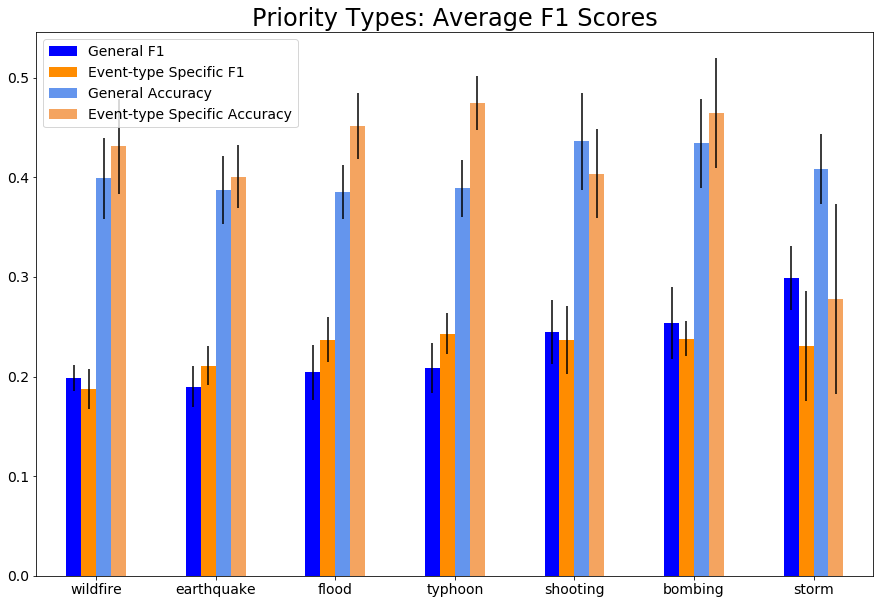

In [54]:
#priority
infile = open('Trec_data/prio_results.pkl','rb')
prioDF = pickle.load(infile)
infile.close()
prioDF

plt.figure(figsize=(15, 10))
ax = plt.axes()

genF1 = [item for item in prioDF['avgF1Gen']]
std_gen = [item for item in prioDF['semF1Gen']]
std_spec = [item for item in prioDF['semF1Spec']]
specF1 = [item for item in prioDF['avgF1Spec']]
index = [item for item in prioDF.index]

genacc = [item for item in prioDF['avgAccGen']]
specacc = [item for item in prioDF['avgAccSpec']]
std_genacc = [item for item in prioDF['semAccGen']]
std_specacc = [item for item in prioDF['semAccSpec']]

df_prio = pd.DataFrame({'General F1': genF1,

                   'Event-type Specific F1': specF1, 'General Accuracy': genacc, 
                        
                    'Event-type Specific Accuracy': specacc}, index=index)

ax.set_title('Priority Types: Average F1 Scores', fontsize = 24)
ax = df_prio.plot.bar(rot=0, ax=ax, yerr = [std_gen, std_spec, std_genacc, std_specacc], 
                      color=['blue', 'darkorange', 'cornflowerblue', 'sandybrown'])

plt.show()

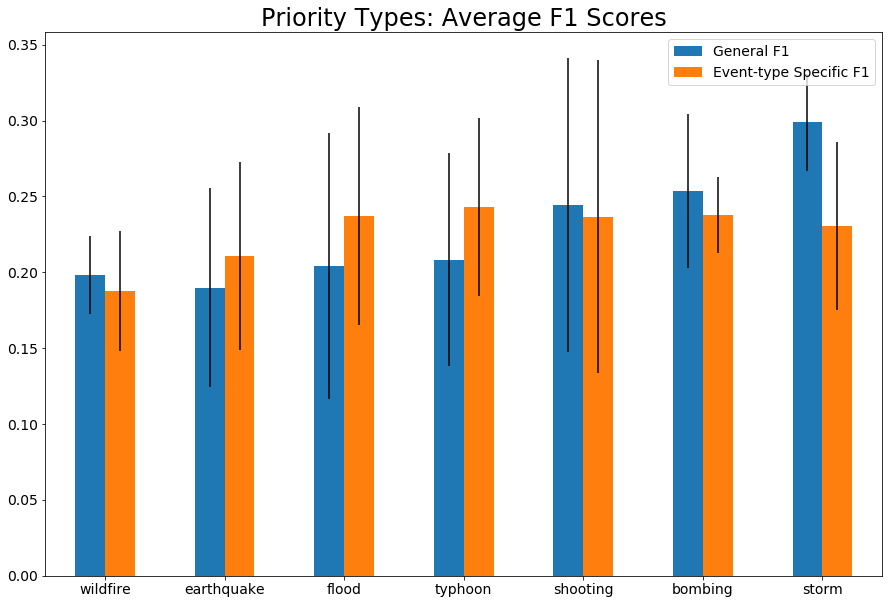

In [86]:
#priority

plt.figure(figsize=(15, 10))
ax = plt.axes()

genF1 = [item for item in prioDF['avgF1Gen']]
std_gen = [item for item in prioDF['stdF1Gen']]
std_spec = [item for item in prioDF['stdF1Spec']]
specF1 = [item for item in prioDF['avgF1Spec']]
index = [item for item in prioDF.index]

genacc = [item for item in prioDF['avgAccGen']]
specacc = [item for item in prioDF['avgAccSpec']]
std_genacc = [item for item in prioDF['stdAccGen']]
std_specacc = [item for item in prioDF['stdAccSpec']]

df_prio = pd.DataFrame({'General F1': genF1,

                   'Event-type Specific F1': specF1}, index=index)

ax.set_title('Priority Types: Average F1 Scores', fontsize = 24)
ax = df_prio.plot.bar(rot=0, ax=ax, yerr = [std_gen, std_spec])

plt.show()

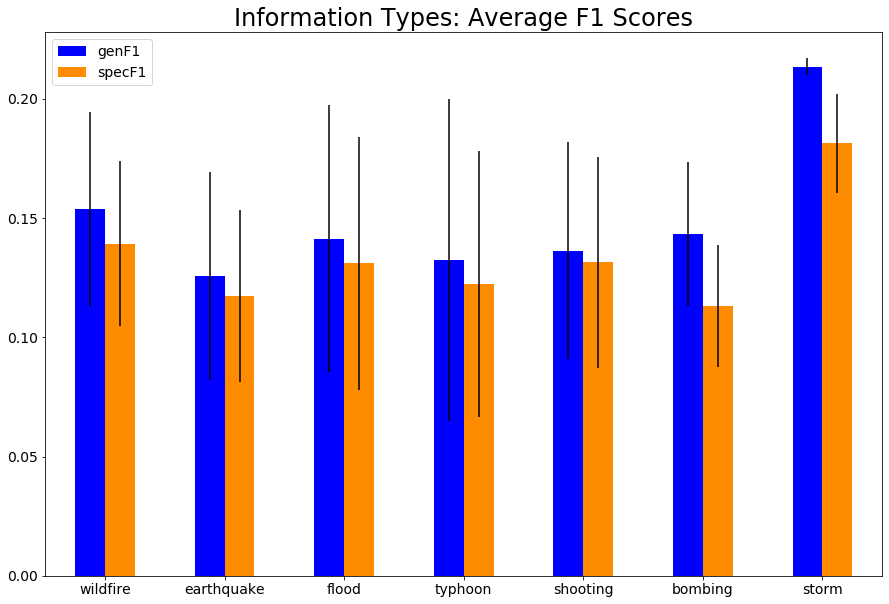

In [111]:
#categories
infile = open('cat_results.pkl','rb')
catDF = pickle.load(infile)
infile.close()

plt.figure(figsize=(15, 10))

ax = plt.axes()

catgenF1 = [item for item in catDF['avgF1Gen']]
catspecF1 = [item for item in catDF['avgF1Spec']]
std_gencat = [item for item in catDF['stdF1Gen']]
std_speccat = [item for item in catDF['stdF1Spec']]
index = [item for item in catDF.index]

df2 = pd.DataFrame({'genF1': catgenF1,

                   'specF1': catspecF1}, index=index)

ax.set_title('Information Types: Average F1 Scores', fontsize = 24)

ax = df2.plot.bar(rot=0, ax=ax, yerr = [std_gencat, std_speccat], color=['blue', 'darkorange'])
plt.show()